In [1]:
# Skeletonization is an automated Deduction in Geometry.
# the skeleton is the set of points, where two or more wavefronts meet
# skeletonization - computation of a skeleton of some shape, widely used in image processing and visualisation

# import the necessary libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage.morphology import skeletonize
from skimage import data
from skimage.util import invert
from skimage.morphology import medial_axis
import scipy
import matplotlib.image as mpimg
import math
import scipy.misc
from scipy.misc import *
from skimage import io, transform

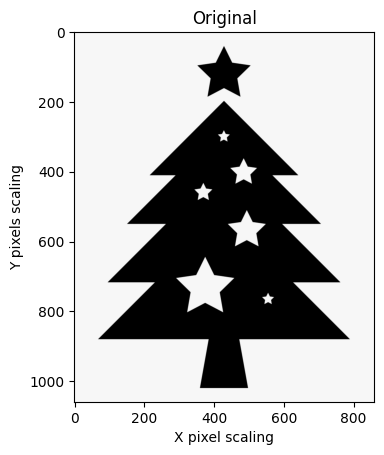

In [74]:
# plot the original image
plt.title("Original")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread("tree.png")
plt.imshow(image)
plt.show()

# convert RGB image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [77]:
# invert the image
image = mpimg.imread("tree.png")

# perform the first skeletonizations
skeleton = skeletonize(image)
skeleton_lee = skeletonize(image, method='lee')

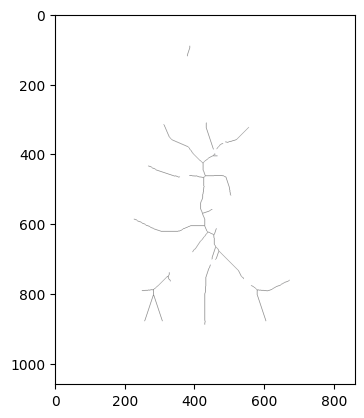

In [83]:
plt.imshow(skeleton)

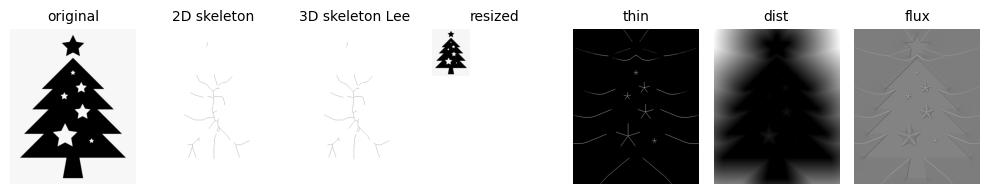

In [82]:
# Display results for Skeleton. You can see unwanted skeleton branches around.
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=10)

# Zha Method 1984 - A fast parallel algorithm for thinning digital patterns. Certain pixels are selectively removed.
ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('2D skeleton', fontsize=10)

# Lee Method 1994 - is designed to be used on 3-D images, and is selected automatically for those.
# For illustrative purposes, we apply this algorithm to a 2-D image.
ax[2].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('3D skeleton Lee', fontsize=10)

# Resize to 30% of original size
ax[3].imshow(resizedImage, cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('resized', fontsize=10)

# Thinning method - works similar to skeletonization, certain pixels are removed.
ax[4].imshow(skeletonImage, cmap=plt.cm.gray)
ax[4].axis('off')
ax[4].set_title('thin', fontsize=10)

# Dist Image - exact euclidean distance measure, closest background element.
ax[5].imshow(distImage, cmap=plt.cm.gray)
ax[5].axis('off')
ax[5].set_title('dist', fontsize=10)

# Flux Image - Luminous flux is the measure of brightness of a light source.
ax[6].imshow(fluxImage, cmap=plt.cm.gray)
ax[6].axis('off')
ax[6].set_title('flux', fontsize=10)


fig.tight_layout()
plt.show()

In [50]:
fileName = "tree.png"

In [51]:
I=mpimg.imread(fileName)
I2 = io.imread("tree.png")

In [52]:
# Convert image to grayscale
I = rgb2gray(I)

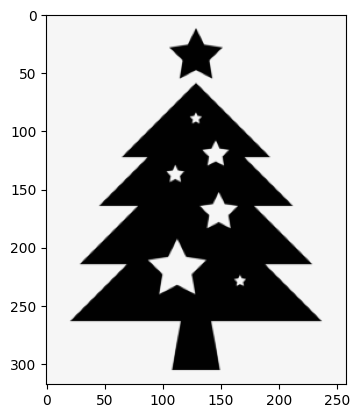

In [81]:
# Obtain the size of the image
h, w, c = I2.shape

# Resize the image to 0.3 times of it's original size
h_new, w_new = (int)(h * 0.3), (int)(w * 0.3)

# new resized image
resizedImage = transform.resize(I2, (h_new, w_new))


plt.imshow(resizedImage)
plt.show()

#print(I2.shape)

In [54]:
print(resizedImage.shape)

(106, 86, 4)


In [55]:
# Define the tuning parameters for flux image.
# Number of samples is related to the number of points this algorithm considers around a shrinking disk.
number_of_samples = 30
epsilon = 1
flux_threshold = 8

In [56]:
import scipy.ndimage.morphology as morphOps

In [57]:
# distImage - Exact euclidean distance transform.
# In addition to the distance transform, the feature transform can be calculated.
# In this case the index of the closest background element is returned along the first axis of the result.
distImage,IDX = morphOps.distance_transform_edt(I,return_indices=True);

<ipython-input-57-db271c3d4afb>:2: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  distImage,IDX = morphOps.distance_transform_edt(I,return_indices=True);


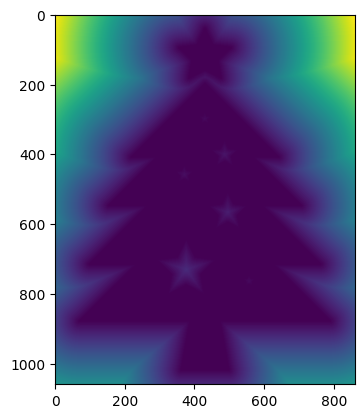

In [58]:
plt.imshow(distImage)

In [59]:
# sample a set of points around a shrinking disk.
# The formula for magnetic flux is Φ = B * A * cos(θ), where B is the magnetic field strength, A is the area, and θ is the angle between the magnetic field and the area vector.
def sample_sphere_2D(number_of_samples):
    sphere_points = np.zeros((number_of_samples,2))
    alpha = (2*math.pi)/(number_of_samples)
    for i in range(number_of_samples):
        sphere_points[i][0] = math.cos(alpha*(i-1))
        sphere_points[i][1] = math.sin(alpha*(i-1))
    return sphere_points

In [61]:
sphere_points = sample_sphere_2D(number_of_samples)

In [62]:
def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

In [63]:
# Flux - measure of the number of electric or magnetic field lines passing through a surface in a given amount time.
# Field lines provide a mechanism for visualizing the magnitude and direction of the field being measured.
# They are imaginary lines that follow different patterns, depending on the field type: electric or magnetic
# The electric flux is then just the electric field times the area of the sphere.
def compute_aof(distImage,IDX, sphere_points, epsilon):

    m = distImage.shape[0]
    n = distImage.shape[1]
    normals = np.zeros(sphere_points.shape)
    fluxImage = np.zeros((m,n))
    for t in range(0,number_of_samples):
        normals[t] = sphere_points[t]
    sphere_points = sphere_points * epsilon

    XInds = IDX[0]
    YInds = IDX[1]

    for i in range(0,m):
        for j in range(0,n):
            flux_value = 0
            if (distImage[i][j] > -1.5):
                if( i > epsilon and j > epsilon and i < m - epsilon and j < n - epsilon ):
#                   sum over dot product of normal and the gradient vector field (q-dot)
                    for ind in range (0,number_of_samples):

#                       a point on the sphere
                        px = i+sphere_points[ind][0]+0.5;
                        py = j+sphere_points[ind][1]+0.5;

#                       the indices of the grid cell that sphere points fall into
                        cI = math.floor(i+sphere_points[ind][0]+0.5)
                        cJ = math.floor(j+sphere_points[ind][1]+0.5)

#                       closest point on the boundary to that sphere point

                        bx = XInds[cI][cJ]
                        by = YInds[cI][cJ]
#                       the vector connect them
                        qq = [bx-px,by-py]

                        d = np.linalg.norm(qq)
                        if(d!=0):
                            qq = qq / d
                        else:
                            qq = [0,0]
                        flux_value = flux_value + np.dot(qq,normals[ind])
            fluxImage[i][j] = flux_value
    return fluxImage

In [72]:
# computation for 1 tree picture takes 5 minutes
fluxImage = compute_aof(distImage,IDX,sphere_points,epsilon)

In [65]:
print(fluxImage.shape)

(1060, 860)


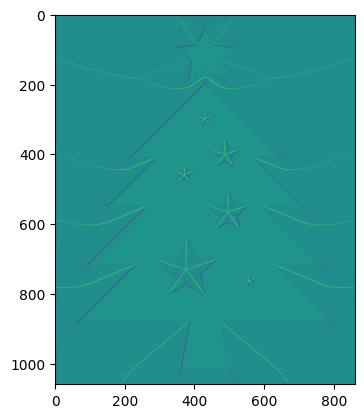

In [68]:
plt.imshow(fluxImage)

In [69]:
#Thinning method - works similar to skeletonization, certain pixels are removed.skeletonImage = fluxImage
skeletonImage[fluxImage < flux_threshold] = 0
skeletonImage[fluxImage > flux_threshold] = 1

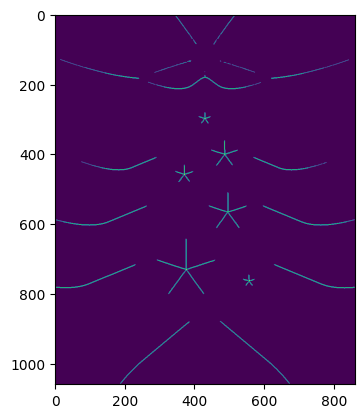

In [70]:
#thin
plt.imshow(skeletonImage)

In [ ]:
https://datacarpentry.org/image-processing/01-introduction.html
https://support.ptc.com/help/mathcad/r9.0/en/index.html#page/PTC_Mathcad_Help/example_thinning_and_skeletonization.html#
https://www.sciencedirect.com/topics/engineering/skeletonization#:~:text=Skeletonization%20provides%20a%20compact%20yet,tracking%2C%20recognition%2C%20and%20compression.
https://scikit-image.org/docs/dev/auto_examples/
https://www.researchgate.net/publication/228778618_The_Geometry_of_Minimal_Surfaces_of_Finite_Genus_I_Curvature_Estimates_and_Quasiperiodicity
https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
https://adg2023.matf.bg.ac.rs/
https://www.researchgate.net/publication/304425584_Proceedings_of_ADG_2016
https://homepages.inf.ed.ac.uk/rbf/HIPR2/skeleton.htm
https://www.sciencedirect.com/science/article/abs/pii/B978008101291800002X
https://www.researchgate.net/publication/356179465_A_novel_fully_parallel_skeletonization_algorithm
https://en.wikipedia.org/wiki/Grassfire_transform
http://www.alma.inaf.it/images/Image_analysis2.pdf
https://support.ptc.com/help/mathcad/r9.0/en/index.html#page/PTC_Mathcad_Help/about_morphological_processing_functions.html#
https://www.cse.wustl.edu/~taoju/research/ma_final.pdf
https://www.techtarget.com/whatis/definition/flux#:~:text=The%20Greek%20letter%20phi%20(%CE%A6,vector%20and%20the%20field%20lines.
https://rjallain.medium.com/the-good-the-bad-and-the-physics-of-gausss-law-853f6cd97302
https://github.com/mrezanejad/2DAOFSkeleton_Python
https://www.mathworks.com/matlabcentral/fileexchange/41108-efficient-implementation-for-spherical-flux-computation-3d
https://en.wikipedia.org/wiki/Topological_skeleton
https://skeleton-analysis.org/stable/getting_started/getting_started.html#extracting-a-skeleton-from-an-image
https://www.sciencedirect.com/science/article/abs/pii/S0376738818329442#:~:text=The%20threshold%20flux%20is%20a,to%20determine%20the%20threshold%20flux.